В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test.
Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


In [5]:

boston = fetch_california_housing()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Задание 1

Бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигнориуйте этот множитель при дальнейшем построении алгоритма.

$L(y, z) = (y - z)^2$

$L'_z(y, z) = 2(z - y) => (z - y)$

In [41]:

from sklearn.metrics import r2_score

y_pred_train = np.full(X_train.shape, np.mean(y_train))
y_pred_test = y_train.copy()

class GradientBoostingModel:
    def __init__(self,
                 n_estimators: int = 100,
                 learning_rate = lambda i: 0.1,
                 max_depth: int = 3,
                 random_state: int = 42):
        self.trees = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.avr_y = 0
        self.random_state = random_state
    
    def fit(self, X, y):
        self.avr_y = np.mean(y)
        y_pred = np.full(y.shape, self.avr_y)
        for i in range(self.n_estimators):
            r = y - y_pred
            new_tree = tree.DecisionTreeRegressor(
                max_depth=self.max_depth, 
                random_state=self.random_state
            )
            new_tree.fit(X, r)
            y_pred += self.learning_rate(i) * new_tree.predict(X)
            self.trees.append(new_tree)
        
    def predict(self, X):
        y_pred = np.full((X.shape[0], ), self.avr_y).astype(np.float64)
        for i, reg_tree in enumerate(self.trees):
            y_pred += self.learning_rate(i) * reg_tree.predict(X)
        return y_pred
        
gbm = GradientBoostingModel()
gbm.fit(X_train, y_train)

y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train) ** 0.5)
print("R2 Score train:", r2_score(y_train, y_pred_train))

print("Test RMSE:", mean_squared_error(y_test, y_pred_test) ** 0.5)
print("R2 Score test:", r2_score(y_test, y_pred_test))



Train RMSE: 0.5085602878054316
R2 Score train: 0.8061675157085277
Test RMSE: 0.5383911867895413
R2 Score test: 0.780939310808717


### Задание 2
Заведите массив для объектов DecisionTreeRegressor (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.
В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X:

`def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]`
    
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE.

In [46]:
gbm = GradientBoostingModel(n_estimators=50, learning_rate=lambda i: 0.9, max_depth=5)
gbm.fit(X_train, y_train)

y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train) ** 0.5)
print("R2 Score train:", r2_score(y_train, y_pred_train))

print("Test RMSE:", mean_squared_error(y_test, y_pred_test) ** 0.5)
print("R2 Score test:", r2_score(y_test, y_pred_test))


Train RMSE: 0.3342946628726641
R2 Score train: 0.9162469638702488
Test RMSE: 0.5412955700543535
R2 Score test: 0.7785694640418285



### Задание 3

Двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как ответ в пункте 3. В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным.

In [49]:

gbm = GradientBoostingModel(
    n_estimators=50, 
    learning_rate=lambda i: 0.9 / (1.0 + i), 
    max_depth=5,
)
# PS, при base / (1.0 + i * 0.1) R2 Score test: 0.8099317468893706
gbm.fit(X_train, y_train)

y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train) ** 0.5)
print("R2 Score train:", r2_score(y_train, y_pred_train))

print("Test RMSE:", mean_squared_error(y_test, y_pred_test) ** 0.5)
print("R2 Score test:", r2_score(y_test, y_pred_test))


Train RMSE: 0.5229285071988655
R2 Score train: 0.7950601994167152
Test RMSE: 0.5670604318332603
R2 Score test: 0.7569882605467848


### Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера:

  1. С увеличением числа деревьев начиная с некоторого момента качество работы градиентного бустинга не меняется существенно.
  2. С увеличением числа деревьев начиная с некоторого момента градиентный бустинг начинает переобучаться.
  3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться
  4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [54]:

gbr = GradientBoostingRegressor(
    n_estimators=50, 
    learning_rate=0.9, 
    max_depth=5,
    random_state=42,
)

gbr.fit(X_train, y_train)

y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train) ** 0.5)
print("R2 Score train:", r2_score(y_train, y_pred_train))

print("Test RMSE:", mean_squared_error(y_test, y_pred_test) ** 0.5)
print("R2 Score test:", r2_score(y_test, y_pred_test))


Train RMSE: 0.3342946628726641
R2 Score train: 0.9162469638702488
Test RMSE: 0.5456027928524239
R2 Score test: 0.7750314884121761


#### Зависимость от числа деревьев

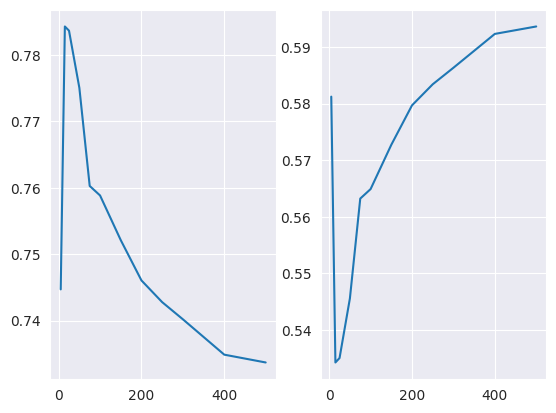

In [59]:
tree_count = [5, 15, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500]
r2_list = []
rmse_list = []

for cnt in tree_count:
    gbr = GradientBoostingRegressor(
        n_estimators=cnt,
        learning_rate=0.9,
        max_depth=5,
        random_state=42,
    )
    gbr.fit(X_train, y_train)
    r2 = r2_score(y_test, gbr.predict(X_test))
    rmse = mean_squared_error(y_test, gbr.predict(X_test)) ** 0.5
    r2_list.append(r2)
    rmse_list.append(rmse)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(tree_count, r2_list, label='r2')
ax2.plot(tree_count, rmse_list, label='rmse')
    

#### Зависимость от глубины дерева

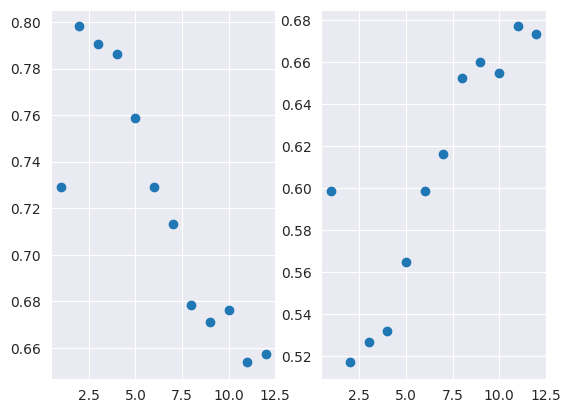

In [60]:

max_depth_count = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
r2_list = []
rmse_list = []

for depth in max_depth_count:
    gbr = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.9,
        max_depth=depth,
        random_state=42,
    )
    gbr.fit(X_train, y_train)
    r2 = r2_score(y_test, gbr.predict(X_test))
    rmse = mean_squared_error(y_test, gbr.predict(X_test)) ** 0.5
    r2_list.append(r2)
    rmse_list.append(rmse)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(max_depth_count, r2_list, 'o', label='r2')
ax2.plot(max_depth_count, rmse_list, 'o', label='rmse')



Ответы: 2 3


### Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE. В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда.

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

print("Test r2 linear regressor:", r2_score(y_test, lr.predict(X_test)))
print("Test rmse linear regressor:", mean_squared_error(y_test, lr.predict(X_test)) ** 0.5)

print("Test r2 gradient boosting regressor:", r2_score(y_test, gbr.predict(X_test)))
print("Test rmse gradient boosting regressor:", mean_squared_error(y_test, gbr.predict(X_test)) ** 0.5)


Test r2 linear regressor: 0.5910509795491352
Test rmse linear regressor: 0.7356145375446768
Test r2 gradient boosting regressor: 0.7813223330965439
Test rmse gradient boosting regressor: 0.5379202989168684
